## 0. Import des librairies

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2


from src import import_auto      # Ma fonction == optimisation (voir import_auto.py)
from src import negatif_test

## 1. Optimisation et nettoyage des données

In [27]:
# Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 200 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_train
import_auto.import_fichier_train()

In [28]:
# Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 3 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_test
import_auto.import_fichier_test()

## 2. Import des Datasets

In [29]:
# ImageDataGenerator génère des lots de données d'image vectorielles, convertissant les coefficients RVB compris entre 0 et 255 en valeurs cibles comprises entre 0 et 1 par mise à l'échelle avec un facteur de 1/255 à l' aide de la remise à l' échelle

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,           # shear_range est utilisé pour appliquer de manière aléatoire des                                                                                                     transformations de cisaillement
                                   zoom_range = 0.2,            # zoom_range est utilisé pour zoomer aléatoirement à l'intérieur                                                                                                      des images
                                   horizontal_flip = True)      # horizontal_flip est utilisé pour retourner au hasard la moitié                                                                                                      des images horizontalement

test_datagen = ImageDataGenerator(rescale = 1./255)


# J'importe les images une par une à partir des répertoires en utilisant .flow_from_directory et y appliquons ImageDataGenerator.
train_generator = train_datagen.flow_from_directory(
    directory = "data/dataset_reduit_train",                    # Choix de mon repertoire
    target_size = (32,32),                                      # Je converti les images de leur taille d'origine à notre target_size
    batch_size = 32,                                            # Nombre batch_size qui fait référence au nombre d'exemples                                                                                                         d'entraînement utilisés dans une itération                                 
    class_mode = "categorical"                                  # Nous définissons le class_mode sur catégorique indiquant que                                                                                                        nous avons plusieurs classes (a à z) à prédire.

)

test_generator = test_datagen.flow_from_directory(
    directory = "data/dataset_reduit_test",
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"

)

Found 372451 images belonging to 27 classes.
Found 105 images belonging to 27 classes.


## 3. Definition du modèle d'architecture

In [30]:
# Création d'un modèle séquentiel qui permet de définir l'architecture CNN couche par couche à l'aide de la fonction .add .Nous ajoutons d'abord une couche de convolution avec 32 filtres de taille 3X3 sur les images d'entrée et la passons à travers la fonction d'activation 'relu'.Nous effectuons ensuite des opérations MaxPooling en utilisant un pool de taille 2X2 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (32,32,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Ces couches sont ensuite répétées à nouveau pour améliorer les performances du modèle.

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Enfin, nous aplatissons notre matrice résultante et la passons à travers une couche dense composée de 128 nœuds. Celui-ci est ensuite connecté à la couche de sortie constituée de 26 nœuds, chaque nœud représentant un alphabet

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 27, activation = "softmax"))            # Activation softmax qui convertit les scores en une distribution de probabilité normalisée, et le                                                                  nœud avec la probabilité la plus élevée est sélectionné comme sortie

# Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam 
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_6 (Dense)              (None, 27)               

## 4. Entrainement du modèle

In [31]:
# Je décide de créer 30 répétitions, et j'ai X2 les steps_per_epoch pour augmenter notre précision

entrainement = model.fit_generator(train_generator,
                         steps_per_epoch = 32,
                         epochs = 30,
                         validation_data = test_generator,
                         validation_steps = 32)


Epoch 1/30
32/32 [==============================] - 11s 333ms/step - loss: 2.7325 - accuracy: 0.2559 - val_loss: 3.6025 - val_accuracy: 0.1238
Epoch 2/30
32/32 [==============================] - 8s 251ms/step - loss: 1.9862 - accuracy: 0.4600 - val_loss: 3.4479 - val_accuracy: 0.2667
Epoch 3/30
32/32 [==============================] - 7s 230ms/step - loss: 1.4824 - accuracy: 0.5898 - val_loss: 3.3440 - val_accuracy: 0.3714
Epoch 4/30
32/32 [==============================] - 7s 219ms/step - loss: 1.1254 - accuracy: 0.6650 - val_loss: 3.0269 - val_accuracy: 0.4952
Epoch 5/30
32/32 [==============================] - 6s 198ms/step - loss: 0.9465 - accuracy: 0.7139 - val_loss: 1.5574 - val_accuracy: 0.4571
Epoch 6/30
32/32 [==============================] - 6s 201ms/step - loss: 0.8763 - accuracy: 0.7451 - val_loss: 2.8420 - val_accuracy: 0.5905
Epoch 7/30
32/32 [==============================] - 7s 226ms/step - loss: 0.7941 - accuracy: 0.7607 - val_loss: 2.5150 - val_accuracy: 0.6667
Epoch

## 5. Enregistrement & chargement du modèle

In [32]:
pickle.dump(model, open("mon_model.sav", "wb"))
model = pickle.load(open("mon_model.sav","rb"))

## 6. Création d'une fonction qui renvois l'alphabet associé au résultat

In [33]:
def get_result(result):
    if result[0][0] == 1:
        return("a")
    elif result[0][1] == 1:
        return ("b")
    elif result[0][2] == 1:
        return ("c")
    elif result[0][3] == 1:
        return ("d")
    elif result[0][4] == 1:
        return ("e")
    elif result[0][5] == 1:
        return ("f")
    elif result[0][6] == 1:
        return ("g")
    elif result[0][7] == 1:
        return ("h")
    elif result[0][8] == 1:
        return ("i")
    elif result[0][9] == 1:
        return ("j")
    elif result[0][10] == 1:
        return ("k")
    elif result[0][11] == 1:
        return ("l")
    elif result[0][12] == 1:
        return ("m")
    elif result[0][13] == 1:
        return ("n")
    elif result[0][14] == 1:
        return ("o")
    elif result[0][15] == 1:
        return ("p")
    elif result[0][16] == 1:
        return ("q")
    elif result[0][17] == 1:
        return ("r")
    elif result[0][18] == 1:
        return ("s")
    elif result[0][19] == 1:
        return ("t")
    elif result[0][20] == 1:
        return ("u")
    elif result[0][21] == 1:
        return ("v")
    elif result[0][22] == 1:
        return ("w")
    elif result[0][23] == 1:
        return ("x")
    elif result[0][24] == 1:
        return ("y")
    elif result[0][25] == 1:
        return ("z")
    elif result[0][26] == 1:                # Création du symbole <3
        return ("<3")

## 7. Purge du dossier contenant les extraits

In [34]:
#Par précaution, le dossier "extraits" est purgé avant le traitement de l'image
d='extraits'
filesToRemove = [os.path.join(d,f) for f in os.listdir(d)]
for f in filesToRemove:
    os.remove(f) 

## 8. Reconaissance de caractères dans une image

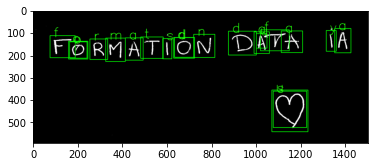

In [35]:
#Chargement de l'image
img = cv2.imread('assets/imagedentrainement.jpeg')
img = cv2.bitwise_not(img)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
_, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#Cette incrémentation a pour but de donner un nom différent aux extraits de l'image
inc = 0

#Cette boucle permet de détecter les extraits, de les enregistrer dans le dossier "extraits", et d'identifier le contenu de l'image

for cnt in contours:
    
    #Récupération des coordonnées des extraits
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    cv2.drawContours(img, cnt, 0, (0), 1)
    x = approx.ravel()[0]
    y = approx.ravel()[1]

    #Détection d'un motif dans l'image
    x, y, w, h = cv2.boundingRect(cnt)

    #Pour prévenir les résultats superflus, des conditions concernant la largeur et la hauteur sont imposées
    if (w > 5 and h > 30):
        inc = inc + 1

        #Création du fichier image contenant l'extrait
        #Note : pour faciliter la reconnaissance, une encadrement de 16 pixels est ajouté
        cv2.imwrite("extraits/extrait" + str(inc) + ".png", img[y - 16 : y + h + 16, x - 16 : x + w + 16]) 

        #Chargement de l'image dans la prédiction
        choix = r"extraits\extrait" + str(inc) + ".png"

        #Prédiction de l'image
        test_image = image.load_img(choix, target_size = (32,32))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        resultat = model.predict(test_image)
        resultat = get_result(resultat)
        
        #Affichage la sélection de l'extrait dans l'image avec le résultat de la reconnaissance
        cv2.rectangle(img,(x - 16,y - 16),(x + w + 16,y + h + 16),(0,255,0),2)
        cv2.putText(img, resultat, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2)
    
#Affichage de l'image contenant le résultat du traitement
plt.imshow(img)

